# Charles Hodgins - LSTM Market Forecasting

### Import Libraries

In [1]:
import datetime as dt
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
plt.style.use("bmh")
%matplotlib inline

### Yahoo Finance API Call

In [2]:
stock = 'NVDA'
period = '10y'
interval = '1d'
dataframe = yf.download([stock], period=period, interval=interval)
dataframe = dataframe.xs('NVDA', level='Ticker', axis=1)

C:\Users\C3hod\AppData\Local\Temp\ipykernel_22764\4240057799.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dataframe = yf.download([stock], period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed


### Plot Stock Price Data

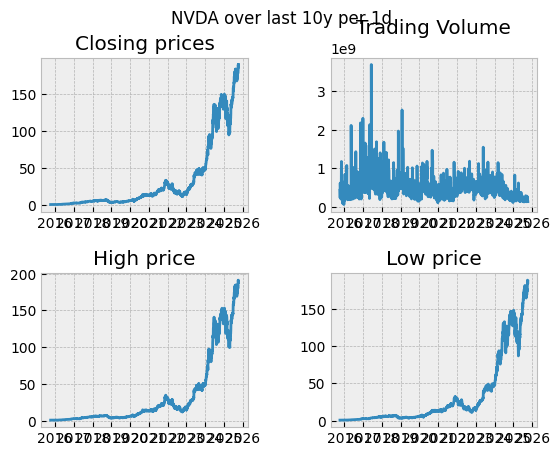

In [3]:
plt.figure()
plt.suptitle(f'{stock} over last {period} per {interval}')

plt.subplot(2,2,1)
plt.plot(dataframe['Close'])
plt.title('Closing prices')

plt.subplot(2,2,2)
plt.plot(dataframe['Volume'])
plt.title('Trading Volume')

plt.subplot(2,2,3)
plt.plot(dataframe['High'])
plt.title('High price')

plt.subplot(2,2,4)
plt.plot(dataframe['Low'])
plt.title('Low price')
    
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

### Define Standardizer Class and preprocessing functions

In [4]:
class ZStandardizer():
    def __init__(self):
        self.mean = 0
        self.std = 0
    
    def fit(self, data: pd.DataFrame):
        self.mean = data.mean()
        self.std = data.std()
        
    def transform(self, data:pd.DataFrame) -> (pd.DataFrame):
        return (data-self.mean)/self.std
    
    def fit_transform(self, data: pd.DataFrame) -> (pd.DataFrame):
        self.fit(data)
        return self.transform(data)
    
    def inverse_transform(self, data:pd.DataFrame) -> (pd.DataFrame):
        return data*self.std + self.mean
    
def calculate_returns(df):
    df['Returns'] = df['Close'].pct_change()
    return df

    
def create_sequences(data, window_size):
    x, y = [], []
    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)


### Hyper Parameters

In [5]:
#######################
#  Dataset Parameters #
#######################
window_size = 3 # 3
train_ratio = 0.9 # 0.9
val_ratio = 0.05 # 0.05
test_ratio = 0.05 # 0.05

#######################
#   Model Parameters  #
#######################
input_size = 1 # 1 
hidden_size = 256 # 300
num_layers = 1 # 1
output_size = 1 # 1
dropout = 0.3 # 0.3

#######################
# Training Parameters #
#######################
num_epochs = 100 # 100
batch_size = 64 # 64
learning_rate = 0.0001 # 0.0001
step_size = 40 # 40
weight_decay = 1e-4 # 1e-4
gamma = 0.4 # 0.4

### Pre-process data

In [6]:
scaler = ZStandardizer()

dataframe = calculate_returns(dataframe)

dataset = dataframe['Close'].dropna().values.reshape(-1,1)

total_len = len(dataset)
train_end = int(total_len*train_ratio)
val_end = int(total_len*(train_ratio+val_ratio))
train_data = dataset[:train_end]
scaler.fit(train_data)
train_data_scaled = scaler.transform(train_data)

val_data_scaled = scaler.transform(dataset[train_end:val_end])
test_data_scaled = scaler.transform(dataset[val_end:])

x_train, y_train = create_sequences(train_data, window_size)

x_val, y_val = create_sequences(val_data_scaled, window_size)

x_test, y_test = create_sequences(test_data_scaled, window_size)
print(len(x_train), len(x_val), len(x_test), '=', sum((len(x_train), len(x_val), len(x_test))))

2259 123 123 = 2505


### Build the train, validation and test datasets and data loaders

In [7]:
x_train_tensor = torch.from_numpy(x_train).float().reshape((x_train.shape[0], x_train.shape[1], 1))
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
    
x_val_tensor = torch.from_numpy(x_val).float().reshape((x_val.shape[0], x_val.shape[1], 1))
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)

x_test_tensor = torch.from_numpy(x_test).float().reshape((x_test.shape[0], x_test.shape[1], 1))
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for x_batch, y_batch in train_loader:
    print("x_batch shape:", x_batch.shape)
    print("y_batch shape:", y_batch.shape)
    break

x_batch shape: torch.Size([64, 3, 1])
y_batch shape: torch.Size([64, 1])


### Define Network Architecture and training function

In [8]:
class ForecasterLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout = 0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 25),
            nn.Linear(25, output_size)
        )

    def forward(self, x):
        # input shape - (batch_size, sequence_length, input_size)
        # lstm_out - (batch, sequence, D*H_out)
        # Back to (batch, seq_len, channels)
        lstm_out, _ = self.lstm(x)
        last_hidden_state = lstm_out[:,-1,:] # shape(batch_size, hidden_size)
        out = self.fc(last_hidden_state)
        return out
    
def training_loop(model, optim, criterion, train_loader, val_loader, epochs,scheduler = 'na'):
    train_losses = []
    val_losses = []
    patience = 20 
    delta = 0.005
    best_val_loss = float("inf") 
    no_improvement_count = 0
    for epoch in range(1, epochs+1):  
        model.train()
        train_loss = 0
        val_loss = 0
        for x_batch, y_batch in train_loader:
            optim.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optim.step()
            train_loss += loss.item() * x_batch.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        #validation phase
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * x_batch.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        if scheduler != 'na':
            scheduler.step()
        
        if val_loss < best_val_loss - delta:
            best_val_loss = val_loss
            no_improvement_count = 0
        else:
            no_improvement_count+=1
        if no_improvement_count >= patience:
            print(f'Stopping early at epoch:{epoch}')
            break
        
        if epoch % 5 == 0 or epoch == 1:
                print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
    return train_losses, val_losses


In [14]:
model = ForecasterLSTM(input_size,hidden_size, num_layers,output_size,dropout)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
lossfunction = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma)

train_losses, val_losses = training_loop(model, optimizer, lossfunction, train_loader, val_loader, num_epochs,scheduler)

c:\Users\C3hod\OneDrive\Documents\NNDL\market-forecasting\.market-forecasting\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/100 | Train Loss: 1110.641064 | Val Loss: 14.708430
Epoch 5/100 | Train Loss: 947.464655 | Val Loss: 0.307354
Epoch 10/100 | Train Loss: 641.672990 | Val Loss: 0.168681
Epoch 15/100 | Train Loss: 482.092652 | Val Loss: 1.140114
Epoch 20/100 | Train Loss: 376.021769 | Val Loss: 0.639930
Epoch 25/100 | Train Loss: 294.872317 | Val Loss: 0.104606
Epoch 30/100 | Train Loss: 231.800151 | Val Loss: 0.047760
Epoch 35/100 | Train Loss: 180.728224 | Val Loss: 0.032759
Epoch 40/100 | Train Loss: 138.481624 | Val Loss: 0.038106
Epoch 45/100 | Train Loss: 123.262978 | Val Loss: 0.035059
Stopping early at epoch:47


### Export Model State to .pth

In [15]:
model_path = 'benchmark_model.pth'
torch.save(model.state_dict(), model_path)   

### Plot Training and Validation Loss

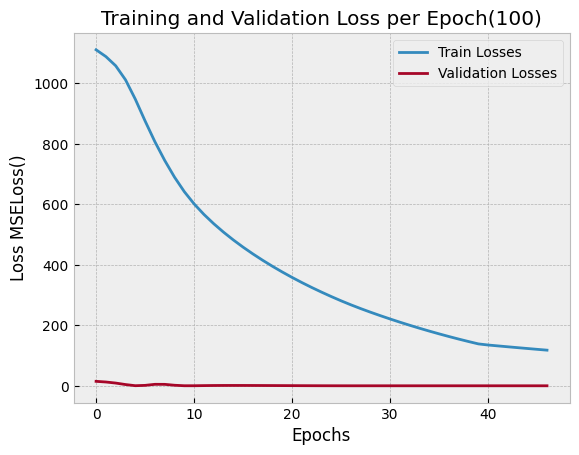

In [16]:
plt.figure()
plt.title(f'Training and Validation Loss per Epoch({num_epochs})')
plt.ylabel(f'Loss {str(lossfunction)}')
plt.xlabel('Epochs')
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train Losses','Validation Losses'])
plt.show()

### Generate Test Predictions

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

predictions = []
labels = []
test_loss = 0

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        loss = lossfunction(outputs, y_batch)
        test_loss += loss.item() * y_batch.size(0)

        predictions.append(outputs)
        labels.append(y_batch)

test_loss /= len(test_loader.dataset)
all_preds = scaler.inverse_transform(torch.cat(predictions))
all_labels = scaler.inverse_transform(torch.cat(labels))
print("Test loss:", test_loss)
print("Sample outputs:", all_preds[-5:])
print("Sample labels:", all_labels[-5:])

Test loss: 0.021229308386280284
Sample outputs: tensor([[192.0481],
        [192.0148],
        [190.8404],
        [187.1384],
        [186.3633]])
Sample labels: tensor([[188.8900],
        [187.6200],
        [185.5400],
        [185.0400],
        [189.1100]])


### Plot Comparison between test predictions and labels

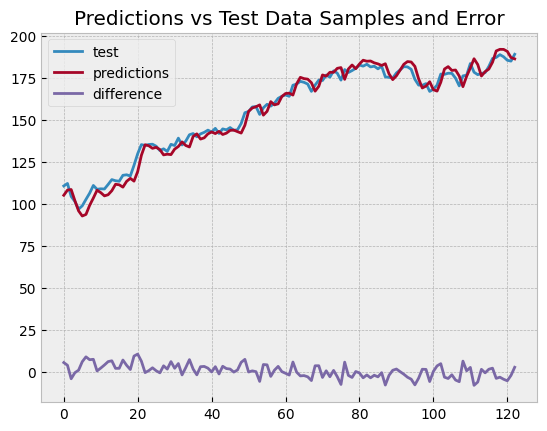

In [18]:
plt.figure()
plt.title(f'Predictions vs Test Data Samples and Error')
plt.plot(all_labels)
plt.plot(all_preds)
plt.plot(all_labels-all_preds)
plt.legend(['test','predictions', 'difference'])
plt.show()
# plt.plot(valid[['Close', 'Predictions']])
